In [125]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import warnings
plt.style.use("seaborn-v0_8")
warnings.filterwarnings('ignore')

In [126]:
period = 20
stocks=yf.download("AAPL")
df=stocks[["Close"]]
df['sma'] = ta.sma(df['Close'], length=period)
df['std'] = df['Close'].rolling(window=20).std()
df=df.dropna()
df['upper_band'] = df['sma'].add(df['std'].mul(2))
df['lower_band'] = df['sma'].add(df['std'].mul(-2))
df

[*********************100%%**********************]  1 of 1 completed


,Close,sma,std,upper_band,lower_band
Date,,,,,
1981-01-12,0.141183,0.138588,0.014643,0.167874,0.109302
1981-01-13,0.136161,0.138979,0.014459,0.167896,0.110062
1981-01-14,0.136719,0.139732,0.013890,0.167511,0.111953
1981-01-15,0.139509,0.141071,0.012355,0.165781,0.116362
1981-01-16,0.138393,0.142215,0.010829,0.163873,0.120558
...,...,...,...,...,...
2023-11-13,184.800003,176.039001,5.524389,187.087778,164.990224
2023-11-14,187.440002,176.553501,6.084116,188.721733,164.385270
2023-11-15,188.009995,177.162001,6.596050,190.354100,163.969902


In [127]:
threshold_percentage = 0.3
df['threshold'] = df['std'] * threshold_percentage

df["Sell"]=np.where(df["Close"].shift()>df["upper_band"]- df['threshold'].shift(),1,0)
df["Buy"]=np.where(df["Close"].shift()<df["lower_band"]+ df['threshold'].shift(),1,0)

Buy_dates=[]
Sell_dates=[]
buys=[]
sells=[]
open_pos=False

for i in range(len(df)):
    if df.Buy.iloc[i]:
        if open_pos==False:
            buys.append(i)
            open_pos=True
            Buy_dates.append(df.iloc[i].name)
    elif df.Sell.iloc[i]:
        if open_pos:
            sells.append(i)
            open_pos=False
            Sell_dates.append(df.iloc[i].name)

if len(buys)>len(sells):
    buys.pop(-1)
    Buy_dates.pop(-1)

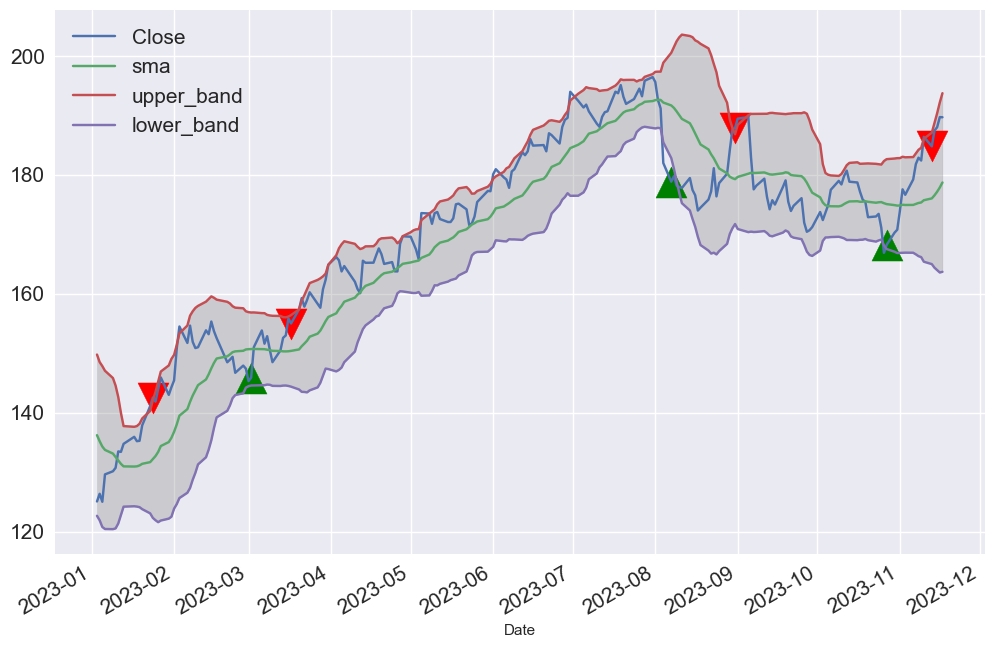

In [128]:
Buy_dates= [date for date in Buy_dates if '2023' in str(date)]
Sell_dates= [date for date in Sell_dates if '2023' in str(date)]
df.loc["2023"][["Close", "sma", "upper_band", "lower_band"]].plot(figsize=(12,8),fontsize=15)
plt.fill_between(df.loc["2023"].index, df.loc["2023"]['upper_band'], df.loc["2023"]['lower_band'], color='grey', alpha=0.3)
plt.scatter(df.loc[Buy_dates].index, df.loc[Buy_dates]['Close'], marker="^", color='g', s=500)
plt.scatter(df.loc[Sell_dates].index, df.loc[Sell_dates]['Close'], marker="v", color='r', s=500)
#plt.scatter(df.loc["2023"][df['Buy'] == 1].index, df.loc["2023"][df['Buy'] == 1]['Close'], color='green', marker='^', label='Buy Signal')
plt.legend(loc="upper left", fontsize=15)
plt.show()

In [131]:
def test_strategy(stock,period,threshold_percentage,invest):
    data=yf.download(stock)
    df=data.Close.to_frame()

    
    df['sma'] = ta.sma(df['Close'], length=period)
    df['std'] = df['Close'].rolling(window=period).std()
    df=df.dropna()
    df['upper_band'] = df['sma'].add(df['std'].mul(2))
    df['lower_band'] = df['sma'].add(df['std'].mul(-2))

    df['threshold'] = df['std'] * threshold_percentage

    df["Sell"]=np.where(df["Close"].shift()>df["upper_band"]- df['threshold'].shift(),1,0)
    df["Buy"]=np.where(df["Close"].shift()<df["lower_band"]+ df['threshold'].shift(),1,0)

    Buy_dates=[]
    Sell_dates=[]
    buys=[]
    sells=[]
    open_pos=False

    for i in range(len(df)):
        if df.Buy.iloc[i]:
            if open_pos==False:
                buys.append(i)
                open_pos=True
                Buy_dates.append(df.iloc[i].name)
        elif df.Sell.iloc[i]:
            if open_pos:
                sells.append(i)
                open_pos=False
                Sell_dates.append(df.iloc[i].name)

    if len(buys)>len(sells):
        buys.pop(-1)
        Buy_dates.pop(-1)
    
    
    check=pd.DataFrame({'buydate':Buy_dates,'selldate':Sell_dates,'buyprice':df.loc[Buy_dates].Close.values,'sellprice':df.loc[Sell_dates].Close.values})
    check["pnl_perc"]=(check.sellprice-check.buyprice)/check.buyprice
    check["cumm+pnl_perc"]=(check["pnl_perc"]+1).cumprod()
    
    profits_perc=(df.loc[check.selldate].Close.values-df.loc[check.buydate].Close.values)/df.loc[check.buydate].Close.values
    list_profits=(profits_perc+1).cumprod()
    net_returns_perc=(list_profits[-1]-1).round(3)*100
    
    inv_ret=invest*(profits_perc+1).cumprod()
    return_inv=inv_ret[-1]
    
    large_loss=profits_perc.min().round(3)*100
    large_profit=profits_perc.max().round(3)*100   
    
    return print("Returns perc= {}%".format(net_returns_perc)), print("Invested return= {}".format(return_inv)), print("Largest Loss= {}%".format(large_loss)), print("Largest Profit= {}%".format(large_profit))

In [140]:
test_strategy("KO", 20, 0.1,1000)

[*********************100%%**********************]  1 of 1 completed
Returns perc= 5571.900000000001%
Invested return= 56718.56626714064
Largest Loss= -44.3%
Largest Profit= 20.7%


(None, None, None, None)